In [1]:
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt
import sounddevice as sd
from scipy.io import wavfile
import time
# Custom ============================
import maximumlengthsequence as mls
import impulseresponsemeasurer as irm
import plotutil
import cancellationfilter as cfilt

### Load Impulse responses from file

In [26]:
h = np.loadtxt('ir')

### Record and make filters

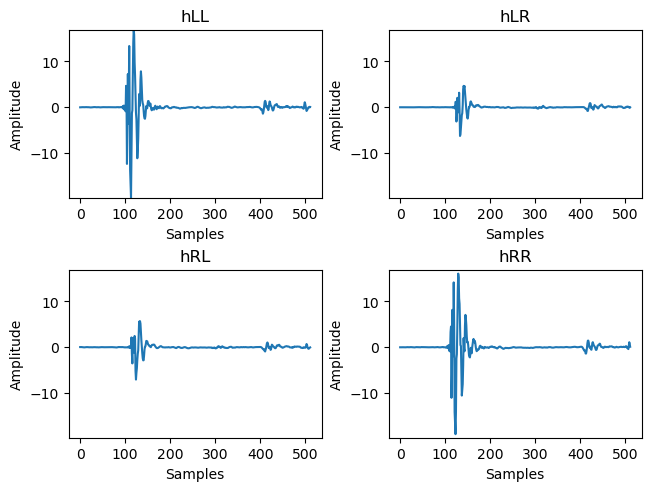

In [2]:
ir = irm.measure_impulse_response(48000)
hstart = 4400
hlength = 512
filterLength = 1024 * 2
filt = cfilt.Cancellation_filter(ir[hstart:hstart+hlength,:], filterLength)
plotutil.plot_impulse_response(ir[hstart:hstart+hlength,:])

np.savetxt('ir',ir)

### Compare using MLS

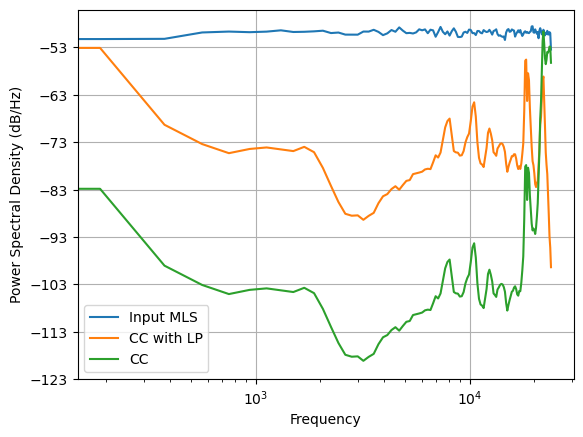

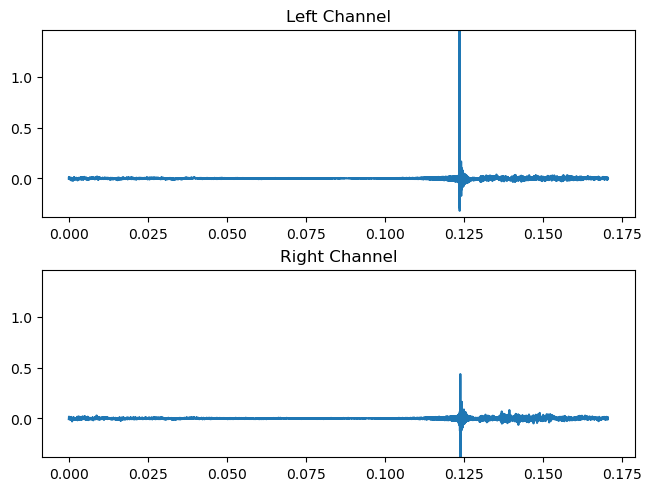

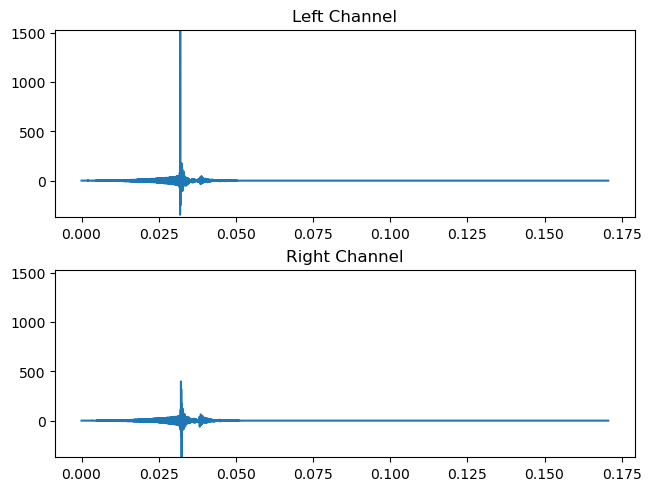

In [14]:
mls_raw, mls_sig = mls.generate_mls_signal(48000)

plt.psd(mls_sig, Fs=48000, label='Input MLS')

mls_sig_unfiltered = np.column_stack((mls_sig, np.zeros((len(mls_sig,),1))))

b = signal.firwin(16, 0.8)
mls_sig = signal.filtfilt(b, 1, mls_sig, padlen=150)    

mls_sig = np.column_stack((mls_sig, np.zeros((len(mls_sig,),1))))
mls_sig_f = filt.filter_stereo(mls_sig)
mls_sig_f_unfiltered = filt.filter_stereo(mls_sig_unfiltered)
plt.psd(mls_sig_f[:,0], Fs=48000, label='CC with LP')
plt.psd(mls_sig_f_unfiltered[:,0], Fs=48000, label='CC')
plt.legend()
plt.xscale('log')
plt.show()

mls_rec = sd.playrec(mls_sig_f, 48000, channels=2, dtype='float32')
sd.wait()
time.sleep(2)
mls_ref = filt.filter_reference(mls_sig)
mls_rec_d = np.column_stack((mls.decode_mls_signal(mls_rec[:,0], mls_raw)[0], mls.decode_mls_signal(mls_rec[:,1], mls_raw)[0]))
mls_ref_d = np.column_stack((mls.decode_mls_signal(mls_ref[:,0], mls_raw)[0], mls.decode_mls_signal(mls_ref[:,1], mls_raw)[0]))
plotutil.plot_stereo(mls_rec_d)
plotutil.plot_stereo(mls_ref_d)

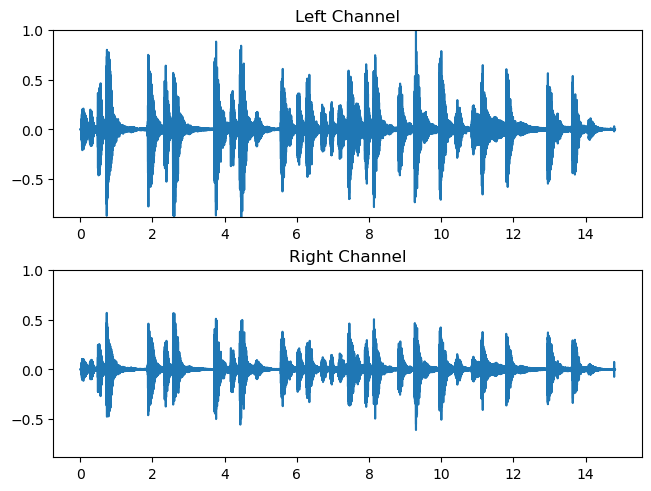

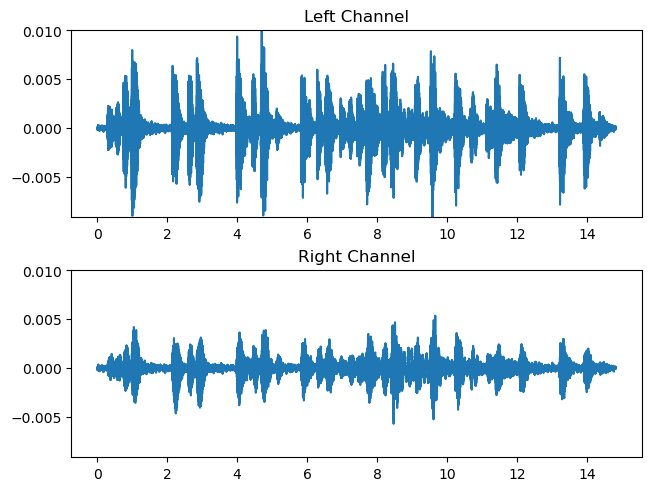

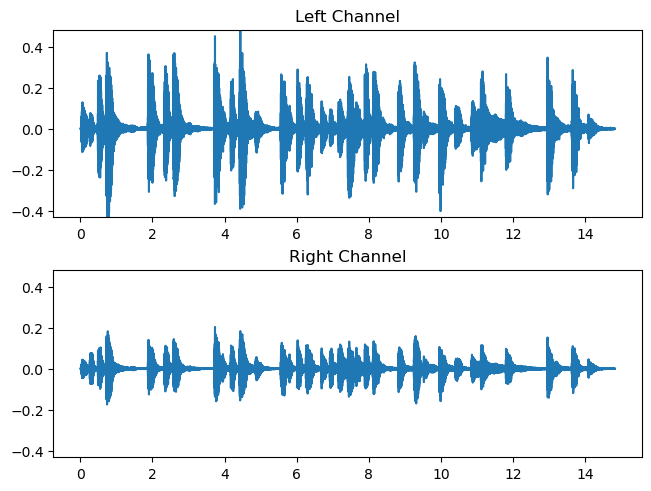

In [5]:
samplerate, data = wavfile.read('piano-loop.wav')
data[:,1] = np.zeros(len(data[:,1]))

b = signal.firwin(16, 0.8)
data[:,0] = signal.filtfilt(b, 1, data[:,0], padlen=150)  

data_f = filt.filter_stereo(data)
data_ref_f = filt.filter_reference(data)
left_recording = sd.playrec(data_f, samplerate, channels=2, dtype='float32')
sd.wait()
time.sleep(2)
plotutil.plot_stereo(data_f)
plotutil.plot_stereo(left_recording)
plotutil.plot_stereo(data_ref_f)

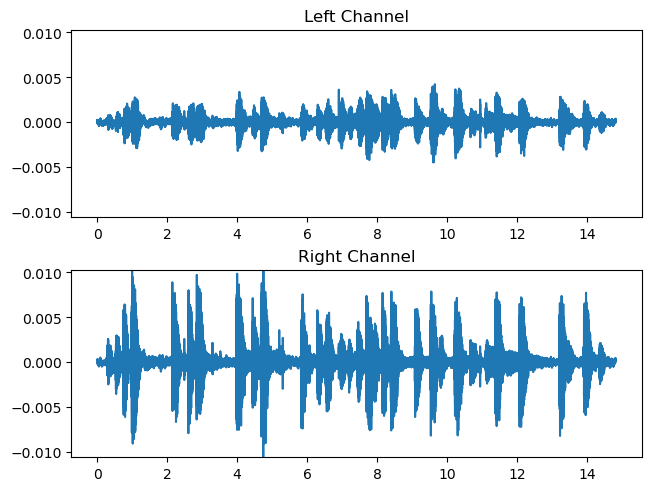

In [68]:
samplerate, data = wavfile.read('piano-loop.wav')
data[:,0] = np.zeros(len(data[:,0]))
data_f = filt.filter_stereo(data)
left_recording = sd.playrec(data_f, samplerate, channels=2, dtype='float32')
sd.wait()
time.sleep(2)

plotutil.plot_stereo(left_recording)

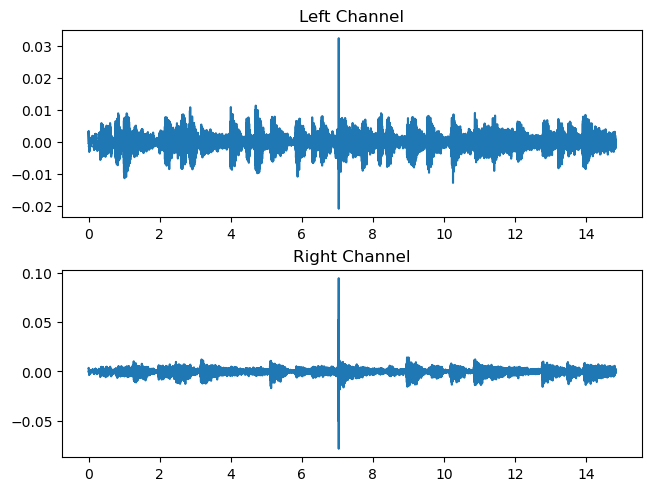

In [59]:
samplerate, data = wavfile.read('cancellation_test_stereo.wav')

stereo_recording = sd.playrec(data*2, samplerate, channels=2, dtype='float32')
sd.wait()
time.sleep(2)

plotutil.plot_playrec(data, stereo_recording)

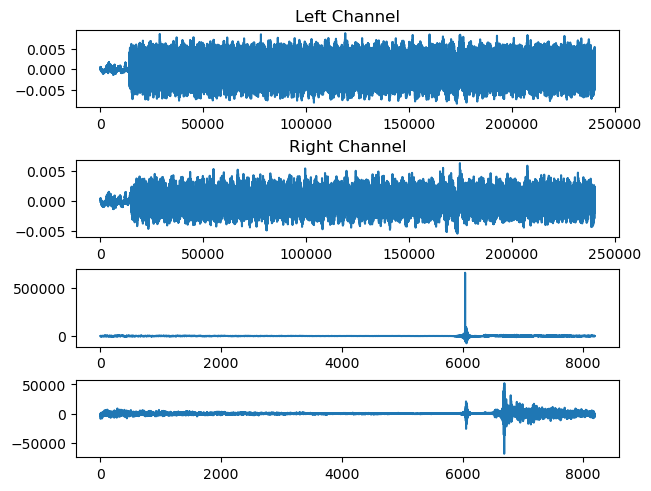

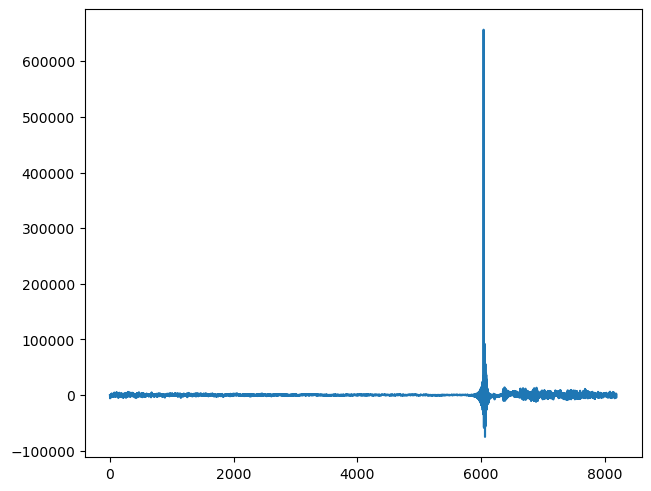

In [60]:
samplerate, data = wavfile.read('excite_left.wav')

fs, mls_data = wavfile.read('mls.wav')

data = data

ex_left_recording = sd.playrec(data, samplerate, channels=2, dtype='float32')
sd.wait()
time.sleep(2)

fig, (ax0, ax1, ax2, ax3) = plt.subplots(4,1,layout='constrained')
ax0.plot(ex_left_recording[:,0])
ax0.set_title("Left Channel")
ax1.plot(ex_left_recording[:,1])
ax1.set_title("Right Channel")
ax2.plot(mls.decode_mls_signal(ex_left_recording[:,0], mls_data)[0])
ax3.plot(mls.decode_mls_signal(ex_left_recording[:,1], mls_data)[0])
plt.show()

fig, ax0 = plt.subplots(1,1,layout='constrained')
ax0.plot(mls.decode_mls_signal(ex_left_recording[:,0], mls_data)[0])
plt.show()

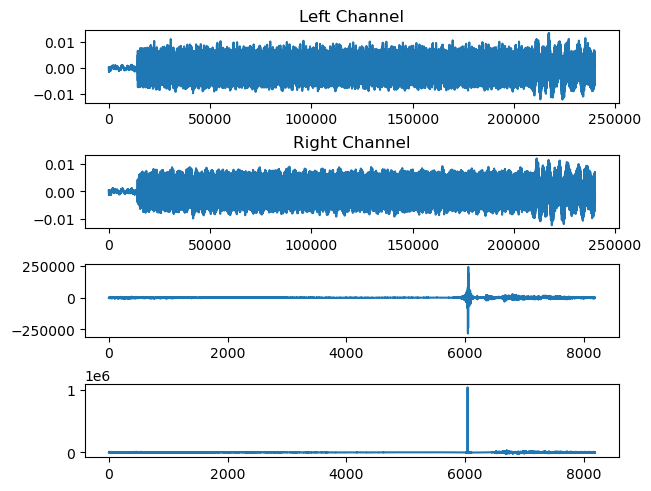

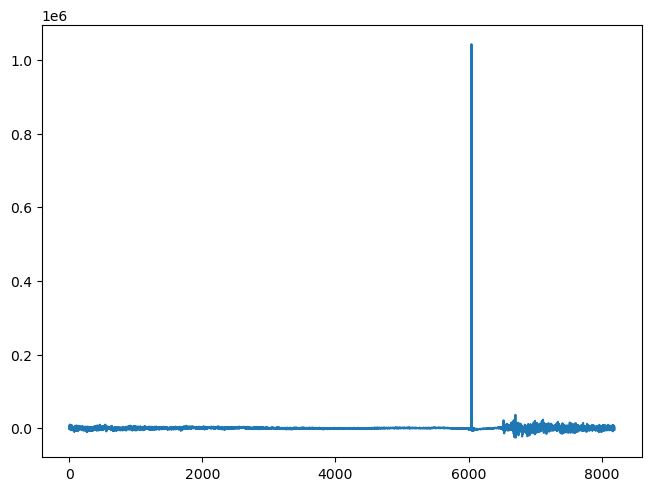

In [61]:
samplerate, data = wavfile.read('excite_right.wav')

fs, mls_data = wavfile.read('mls.wav')

data = data

ex_right_recording = sd.playrec(data, samplerate, channels=2, dtype=
                              'float32')
sd.wait()
time.sleep(2)

fig, (ax0, ax1, ax2, ax3) = plt.subplots(4,1,layout='constrained')
ax0.plot(ex_right_recording[:,0])
ax0.set_title("Left Channel")
ax1.plot(ex_right_recording[:,1])
ax1.set_title("Right Channel")
ax2.plot(mls.decode_mls_signal(ex_right_recording[:,0], mls_data)[0])
ax3.plot(mls.decode_mls_signal(ex_right_recording[:,1], mls_data)[0])
plt.show()

fig, ax0 = plt.subplots(1,1,layout='constrained')
ax0.plot(mls.decode_mls_signal(ex_right_recording[:,1], mls_data)[0])
plt.show()

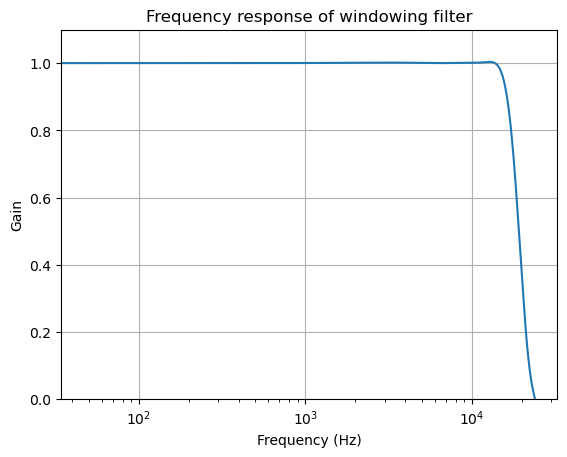

In [15]:
b = signal.firwin(16, 0.8)

w, h = signal.freqz(b, 1, fs=48000)

plt.plot(w, abs(h))
plt.ylim(0, 1.1)
plt.grid(True)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Gain')
plt.title('Frequency response of windowing filter')
plt.xscale('log')
plt.show()